In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/capstone projects/HR_ML.csv')

In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

column_trans = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['departments']),
    (OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

transformed_df = column_trans.fit_transform(df)

In [6]:
df2 = df.copy()

In [7]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.0185, random_state=42)
df2['outlier'] = iso_forest.fit_predict(transformed_df)

df2[df2.outlier == -1]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary,outlier
18,0.45,0.51,2,160,3,1,1,1,sales,low,-1
68,0.76,0.86,5,223,5,1,1,0,product_mng,medium,-1
75,0.11,0.79,7,306,4,0,1,0,product_mng,medium,-1
82,0.79,0.59,4,139,3,0,1,1,management,low,-1
111,0.09,0.85,6,289,4,0,1,0,hr,high,-1
...,...,...,...,...,...,...,...,...,...,...,...
11985,0.22,0.94,3,193,10,0,0,1,management,high,-1
11986,0.90,0.55,3,259,10,1,0,1,management,high,-1
11987,0.74,0.95,5,266,10,0,0,1,management,high,-1
11988,0.85,0.54,3,185,10,0,0,1,management,high,-1


In [8]:
df.drop(df2[df2.outlier == -1].index, axis=0, inplace=True)

In [9]:
df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
11980,0.90,0.76,3,255,7,0,0,0,product_mng,low
11981,0.49,0.49,4,212,7,0,0,0,product_mng,medium
11982,0.60,0.53,2,235,7,0,0,0,IT,medium
11983,0.62,0.85,3,237,3,1,0,0,IT,medium


In [12]:
X = df.drop('left', axis=1)
y = df.left

In [13]:
X.shape, y.shape

((11769, 9), (11769,))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify = y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify = y_train, random_state=42)

In [15]:
column_trans2 = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['departments']),
    (OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

X_train = column_trans2.fit_transform(X_train)
X_test = column_trans2.transform(X_test)
X_val = column_trans2.transform(X_val)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

### Deep Learning ANN

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_ann():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
model = create_ann()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6312 - loss: 0.6641 - val_accuracy: 0.9264 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8612 - loss: 0.3587 - val_accuracy: 0.9406 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8891 - loss: 0.2813 - val_accuracy: 0.9455 - val_loss: 0.1819 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9019 - loss: 0.2429 - val_accuracy: 0.9526 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9183 - loss: 0.2166 - val_accuracy: 0.9540 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9135 - loss: 0.2188 - val_accuracy: 0.9604 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9263 - loss: 

<Axes: >

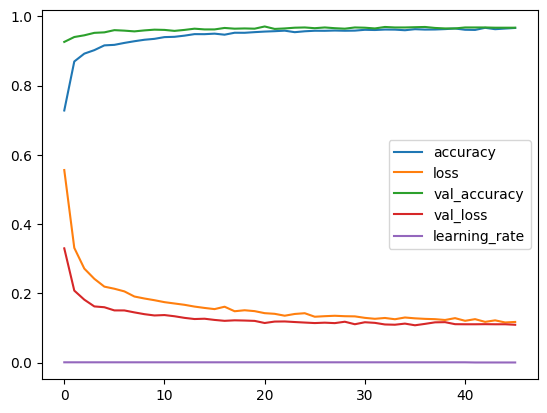

In [20]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [21]:
eval_metric(model, X_train, y_train, X_test, y_test)

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test_Set
[[1940   31]
 [  33  350]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1971
           1       0.92      0.91      0.92       383

    accuracy                           0.97      2354
   macro avg       0.95      0.95      0.95      2354
weighted avg       0.97      0.97      0.97      2354


Train_Set
[[6613   88]
 [ 120 1181]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6701
           1       0.93      0.91      0.92      1301

    accuracy                           0.97      8002
   macro avg       0.96      0.95      0.95      8002
weighted avg       0.97      0.97      0.97      8002



In [22]:
from sklearn.metrics import classification_report

# Get predicted probabilities
y_probs = model.predict(X_test)

# Set a lower threshold (e.g., 0.4 instead of 0.5)
threshold = 0.4
y_pred_adjusted = (y_probs > threshold).astype("int32")

# Evaluate with new threshold
print(classification_report(y_test, y_pred_adjusted))


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1971
           1       0.90      0.91      0.91       383

    accuracy                           0.97      2354
   macro avg       0.94      0.95      0.94      2354
weighted avg       0.97      0.97      0.97      2354



In [34]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

recall_score(y_test, y_pred)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.9138381201044387

### Adding Loss Function

In [23]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        pt = K.exp(-bce)  # Probability of correct class
        focal = alpha * (1 - pt) ** gamma * bce
        return K.mean(focal)
    return loss

def create_ann2():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=focal_loss(),
                  metrics=['recall'])

    return model

In [24]:
model2 = create_ann2()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0827 - recall: 0.4584 - val_loss: 0.0192 - val_recall: 0.3130 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0307 - recall: 0.4374 - val_loss: 0.0150 - val_recall: 0.5739 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - recall: 0.4927 - val_loss: 0.0137 - val_recall: 0.6957 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - recall: 0.4806 - val_loss: 0.0128 - val_recall: 0.7435 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - recall: 0.5408 - val_loss: 0.0128 - val_recall: 0.7739 - learning_rate: 0.0010
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - recall: 0.5341 - val_loss: 0.0122 - val_recall: 0.8174 - learning_rate: 0.0010
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - recall: 0.5640 - val_loss: 0.0118 - val_recall

<Axes: >

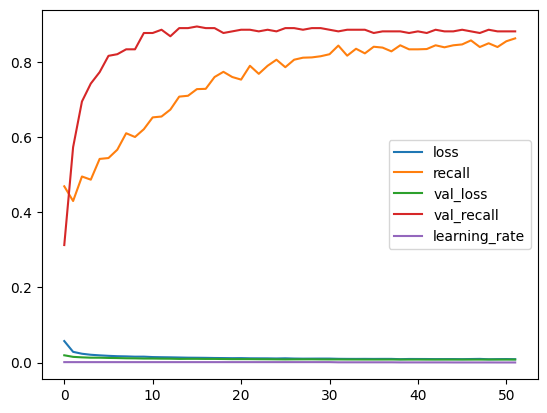

In [25]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

In [26]:
eval_metric(model2, X_train, y_train, X_test, y_test)

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test_Set
[[1932   39]
 [  33  350]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1971
           1       0.90      0.91      0.91       383

    accuracy                           0.97      2354
   macro avg       0.94      0.95      0.94      2354
weighted avg       0.97      0.97      0.97      2354


Train_Set
[[6616   85]
 [ 124 1177]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6701
           1       0.93      0.90      0.92      1301

    accuracy                           0.97      8002
   macro avg       0.96      0.95      0.95      8002
weighted avg       0.97      0.97      0.97      8002



In [35]:
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

recall_score(y_test, y_pred)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


0.9138381201044387

### Increasing Epoch and Patience

In [27]:
model3 = create_ann2()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0727 - recall: 0.4694 - val_loss: 0.0200 - val_recall: 0.3391 - learning_rate: 0.0010
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0294 - recall: 0.4177 - val_loss: 0.0147 - val_recall: 0.5478 - learning_rate: 0.0010
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0236 - recall: 0.4765 - val_loss: 0.0128 - val_recall: 0.7087 - learning_rate: 0.0010
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0205 - recall: 0.5156 - val_loss: 0.0122 - val_recall: 0.7609 - learning_rate: 0.0010
Epoch 5/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - recall: 0.4964 - val_loss: 0.0117 - val_recall: 0.8391 - learning_rate: 0.0010
Epoch 6/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - recall: 0.5776 - val_loss: 0.0111 - val_recall: 0.8565 - learning_rate: 0.0010
Epoch 7/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - recall: 0.5896 - val_loss: 0.0111 - val_recall

<Axes: >

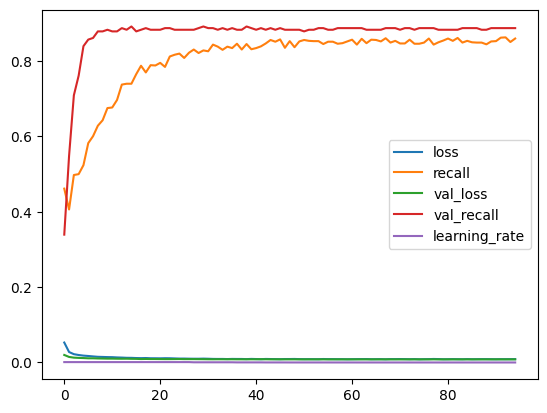

In [28]:
loss_df = pd.DataFrame(model3.history.history)
loss_df.plot()

In [29]:
eval_metric(model3, X_train, y_train, X_test, y_test)

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test_Set
[[1934   37]
 [  33  350]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1971
           1       0.90      0.91      0.91       383

    accuracy                           0.97      2354
   macro avg       0.94      0.95      0.95      2354
weighted avg       0.97      0.97      0.97      2354


Train_Set
[[6618   83]
 [ 119 1182]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6701
           1       0.93      0.91      0.92      1301

    accuracy                           0.97      8002
   macro avg       0.96      0.95      0.95      8002
weighted avg       0.97      0.97      0.97      8002



In [36]:
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

recall_score(y_test, y_pred)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9138381201044387

### Adding More Neurons

In [30]:
def create_ann3():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=focal_loss(),
                  metrics=['recall'])

    return model

In [31]:
model4 = create_ann3()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model4.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0697 - recall: 0.5447 - val_loss: 0.0143 - val_recall: 0.5696 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0255 - recall: 0.5334 - val_loss: 0.0124 - val_recall: 0.7870 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - recall: 0.5527 - val_loss: 0.0116 - val_recall: 0.8522 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - recall: 0.6047 - val_loss: 0.0113 - val_recall: 0.8609 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - recall: 0.6280 - val_loss: 0.0111 - val_recall: 0.8652 - learning_rate: 0.0010
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0155 - recall: 0.6399 - val_loss: 0.0106 - val_recall: 0.8826 - learning_rate: 0.0010
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - recall: 0.6895 - val_loss: 0.0102 - val_recall

<Axes: >

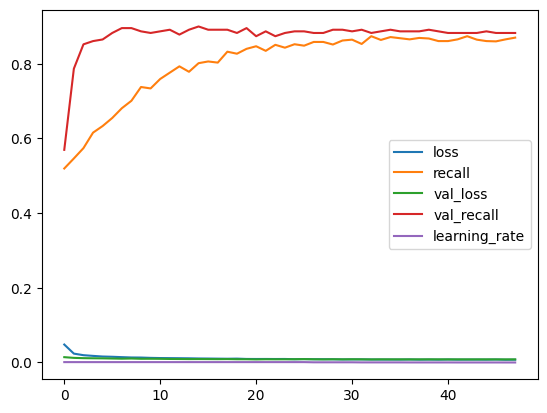

In [32]:
loss_df = pd.DataFrame(model4.history.history)
loss_df.plot()

In [33]:
eval_metric(model4, X_train, y_train, X_test, y_test)

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test_Set
[[1931   40]
 [  32  351]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1971
           1       0.90      0.92      0.91       383

    accuracy                           0.97      2354
   macro avg       0.94      0.95      0.94      2354
weighted avg       0.97      0.97      0.97      2354


Train_Set
[[6616   85]
 [ 115 1186]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6701
           1       0.93      0.91      0.92      1301

    accuracy                           0.98      8002
   macro avg       0.96      0.95      0.95      8002
weighted avg       0.97      0.98      0.97      8002



In [37]:
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

recall_score(y_test, y_pred)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9164490861618799

### Adding Class Weights

In [38]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define class labels (0 and 1)
class_labels = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_train)

# Convert to dictionary format
class_weight_dict = {class_labels[i]: class_weights[i] for i in range(len(class_labels))}

In [39]:
model5 = create_ann3()

model5.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          batch_size=32,
          class_weight=class_weight_dict,
          callbacks=[early_stopping, reduce_lr],
          verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0682 - recall: 0.5525 - val_loss: 0.0156 - val_recall: 0.6606 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0274 - recall: 0.5343 - val_loss: 0.0128 - val_recall: 0.8590 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199 - recall: 0.6169 - val_loss: 0.0121 - val_recall: 0.8903 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - recall: 0.6739 - val_loss: 0.0120 - val_recall: 0.8982 - learning_rate: 0.0010
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - recall: 0.6598 - val_loss: 0.0120 - val_recall: 0.9008 - learning_rate: 0.0010
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - recall: 0.6954 - val_loss: 0.0116 - val_recall: 0.9060 - learning_rate: 0.0010
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0151 - recall: 0.7142 - val_loss: 0.0110 - val_recall

<Axes: >

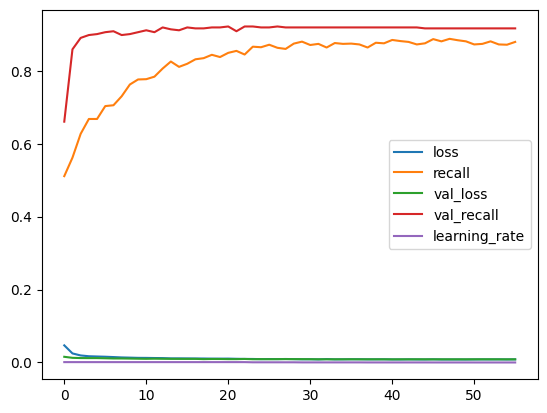

In [40]:
loss_df = pd.DataFrame(model5.history.history)
loss_df.plot()

In [41]:
eval_metric(model5, X_train, y_train, X_test, y_test)

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test_Set
[[1930   41]
 [  31  352]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1971
           1       0.90      0.92      0.91       383

    accuracy                           0.97      2354
   macro avg       0.94      0.95      0.94      2354
weighted avg       0.97      0.97      0.97      2354


Train_Set
[[6586  115]
 [ 114 1187]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6701
           1       0.91      0.91      0.91      1301

    accuracy                           0.97      8002
   macro avg       0.95      0.95      0.95      8002
weighted avg       0.97      0.97      0.97      8002



In [42]:
y_pred = (model5.predict(X_test) > 0.5).astype("int32")

recall_score(y_test, y_pred)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9190600522193212